In [1]:
import warnings
warnings.filterwarnings(action="ignore")

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Import MNIST dataset

In [2]:
from tensorflow.keras.datasets import mnist

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Data Preprocessing

In [4]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


In [5]:
single_image = x_train[0]

print(single_image.shape)

(28, 28)


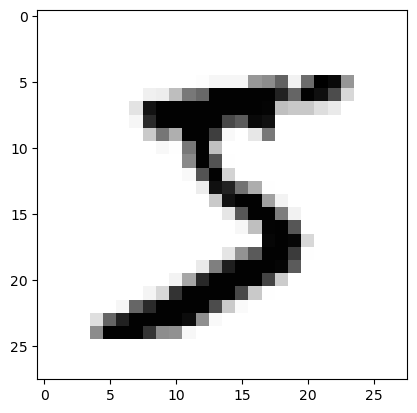

In [6]:
_ = plt.imshow(single_image, cmap='Greys')

In [7]:
# Labels are the actual number they represent/displayed in the image
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

If we are going to pass in our labels as they are, the network would assume it was some sort of continuous values and it would try to predict things like 5.5 or 5.6 etc.

In reality these are just categories, so 5 is not a continuous value but rather the category "Five". So, what we are dealing with here is a multi-class classification problem, and we want to make sure our network understands that.

Hence, we are going to one-hot encode this.

In [8]:
from tensorflow.keras.utils import to_categorical

In [9]:
# Converts a class vector of integers to a binary class matrix
y_example = to_categorical(y_train)

print(y_example.shape)

(60000, 10)


In [10]:
# The class Five is now represented in terms of an index location that corresponds to the class
y_example[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [11]:
# One-hot encode both train and test labels

y_cat_train = to_categorical(y_train, num_classes=10)
y_cat_test = to_categorical(y_test, num_classes=10)

# Normalize the data

In [12]:
# Values range from 0 to 255, typical for a greyscale image
print(single_image.min(), single_image.max())

0 255


Since all images should always have RGB values between 0 and 255, we could normalize our data by simply dividing by 255. This way, all values will fall between 0 and 1.

In [13]:
x_train = x_train/255
x_test = x_test/255

In [14]:
print(x_train[0].min(), x_train[0].max())

0.0 1.0


We also need to reshape our data to let our network know we have a single colour channel. This is done by adding one more dimension that captures the number of colour channels in an image. For example, in a coloured image this dimension would be 3: one for Red, one for Green, and one for Blue.

In [15]:
# batch_size, width, height, colour_channels
x_train = x_train.reshape(60_000, 28, 28, 1)

In [16]:
x_test = x_test.reshape(10_000, 28, 28, 1)

# Building a Convolutional Neural Network

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout

In [18]:
model = Sequential()

model.add(Conv2D(filters=32, 
                 kernel_size=(4,4), 
                 strides=(1,1), 
                 padding='valid',
                 input_shape=(28,28,1),
                 activation="relu"
                )
         )

model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())

model.add(Dense(128, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(64, activation="relu"))

# OUTPUT LAYER
model.add(Dense(10, activation="softmax"))

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 25, 25, 32)        544       
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 128)               589952    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                        

In [20]:
from tensorflow.keras.callbacks import EarlyStopping

In [21]:
early_stop = EarlyStopping(monitor="val_loss", patience=1, verbose=1)

In [22]:
model.fit(x_train, y_cat_train, epochs=10, validation_data=(x_test, y_cat_test), callbacks=[early_stop])

Epoch 1/10
1875/1875 [==============================] - 22s 11ms/step - loss: 0.1832 - accuracy: 0.9439 - val_loss: 0.0512 - val_accuracy: 0.9824
Epoch 2/10
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0666 - accuracy: 0.9793 - val_loss: 0.0418 - val_accuracy: 0.9874
Epoch 3/10
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0478 - accuracy: 0.9853 - val_loss: 0.0350 - val_accuracy: 0.9894
Epoch 4/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0369 - accuracy: 0.9882 - val_loss: 0.0466 - val_accuracy: 0.9858
Epoch 4: early stopping


# Evaluate Performance

In [23]:
from sklearn.metrics import classification_report, confusion_matrix

In [24]:
metrics = pd.DataFrame(model.history.history)

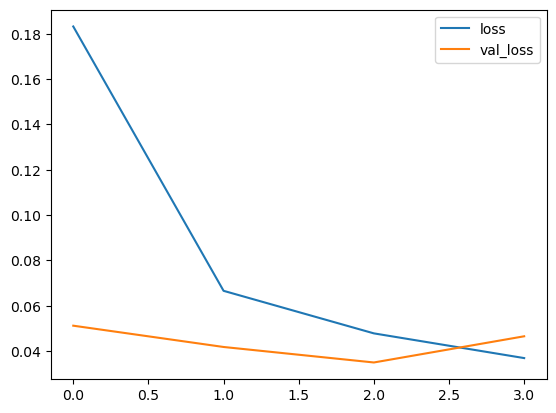

In [25]:
_ = metrics[["loss", "val_loss"]].plot()

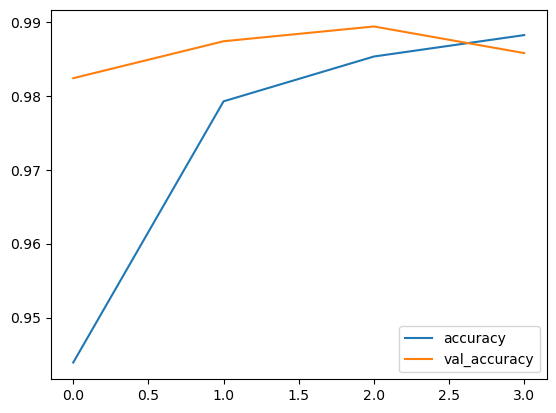

In [26]:
_ = metrics[["accuracy", "val_accuracy"]].plot()

In [27]:
model.evaluate(x_test, y_cat_test, verbose=0)

[0.0465533584356308, 0.98580002784729]

In [28]:
y_pred = np.argmax(model.predict(x_test), axis=-1)

313/313 [==============================] - 1s 4ms/step


In [29]:
y_pred

array([7, 2, 1, ..., 4, 5, 6])

In [30]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       980
           1       1.00      1.00      1.00      1135
           2       0.99      0.97      0.98      1032
           3       0.98      1.00      0.99      1010
           4       0.98      0.99      0.99       982
           5       1.00      0.97      0.98       892
           6       0.98      0.99      0.98       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.97      0.98       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [31]:
print(confusion_matrix(y_test, y_pred))

[[ 979    0    0    0    0    0    0    0    0    1]
 [   0 1130    0    2    0    0    3    0    0    0]
 [   5    0 1004    8    4    0    1    5    4    1]
 [   0    0    0 1006    0    1    0    1    1    1]
 [   1    0    0    0  972    0    2    0    0    7]
 [   4    0    0    9    0  863   11    0    0    5]
 [   7    2    0    0    1    1  946    0    1    0]
 [   1    1    6    0    0    0    0 1018    1    1]
 [   5    0    0    4    2    1    1    4  948    9]
 [   2    2    0    0    8    1    0    4    0  992]]


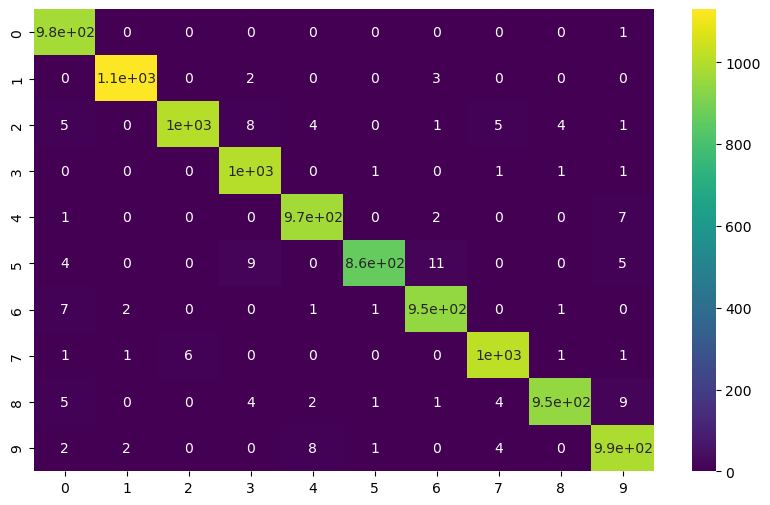

In [32]:
plt.figure(figsize=(10,6))
_ = sns.heatmap(confusion_matrix(y_test, y_pred), cmap="viridis", annot=True)

# Make a prediction of a single image

In [33]:
rand_idx = np.random.randint(0, len(x_test))

my_number = x_test[rand_idx]

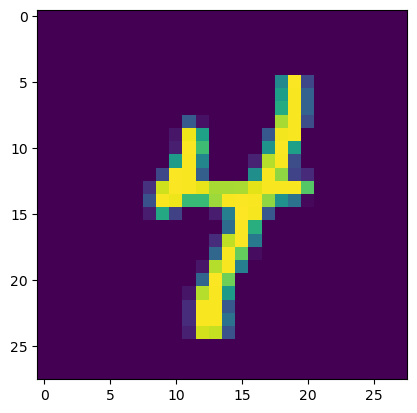

In [34]:
_ = plt.imshow(my_number.reshape(28,28))

In [35]:
my_number_pred = np.argmax(model.predict(my_number.reshape(1,28,28,1)), axis=-1)

1/1 [==============================] - 0s 17ms/step


In [36]:
print("Predicted number: {}\nActual number: {}".format(my_number_pred[0], y_test[rand_idx]))

Predicted number: 4
Actual number: 4
